# Triple Negative Breast Cancer(TNBC) Cell Semantic Segmentation

This notebook applies [U-Net](https://arxiv.org/abs/1505.04597) Convolutional Neural Network for semantic segmentation of TNBC cell images.

The dataset for the task is downloaded from [here](https://zenodo.org/record/1175282#.Xl_4nZMzZQJ) 

**Flow of the notebook:**
- Apply U-Net to standard dataset 
- Plot network's perfomance 
- Show sample test segmentation results 
- Apply U-Net to dataset "overlayed" with canny edges
- Plot network's perfomance 
- Show sample test segmentation results 
- Compare newtork's performance on both datasets

Let's get started!

# Triple Negative Breast Cancer

*Triple-negative breast cancer (TNBC) accounts for about 10-15%  of all breast cancers. These cancers tend to be more common in women younger than age 40, who are African-American.*

*Triple-negative breast cancer differs from other types of invasive breast cancer in that they grow and spread faster, have limited treatment options, and a worse prognosis (outcome)*.  - **American Cancer Society**

Thus early stage cancer detection is required to provide proper treatment to the patient and reduce the risk of death due to cancer as detection of these cancer cells at later stages lead to more suffering and increases chances of death. Semantic segmentation of cancer cell images can be used to improvise the analysis and diagonsis of Breast Cancer! Below is such an attempt.

# U-Net

U-Net is a State of the Art CNN architecture for Bio-medical image segmentation. *The architecture consists of a contracting path to capture context and a symmetric expanding path that enables precise localization.* It's a Fully Convolutional Network(FCN) therefore it can **work with arbitrary size images!**

<img src="img/U-Net_arch.png">

In [1]:
# To ensure GPU is enabled on Colab

# %tensorflow_version 1.x
%matplotlib inline
import tensorflow as tf
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
  # raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: 


2024-07-24 13:05:19.461510: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1- Import required modules

In [2]:
from model import *
from augmentation import *
from metrics import *
from plots import *
from utils import *

In [ ]:
#!unzip data1.zip- Folder which contains test and train datasets

### 1.1- How to arrange Directories for using ImageDataGenerator.flow_from_directory()?

- train
    * images
        * img
    * label
        * img
- test
    * images
        * img
    * label
        * img
        
**train, test, images, label,img** are all directories, where *img* is the directory containing images/segmentation masks .png images

In [3]:
# Loads and initalises the U-Net network

m=unet()
m.summary()

2024-07-24 13:05:25.119655: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-24 13:05:25.119897: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## 2- Model training on Standard Dataset

In [4]:
opt = Adam(lr=1E-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
m.compile(loss=dice_coef_loss, optimizer=opt, metrics=['accuracy', iou, F1, recall, precision]) # Keeping track of these metrics

### 2.1- Why Data Augmentation?

Our training set has **only 33 images** which is nothing when compared to modern day datasets like [ImageNet](http://www.image-net.org/) which has over 1M annotated examples. *But this is generally the case in Bio-medical tasks.* Thus I've used Data Augmentation extensively to increase the dataset.

### 2.2- Why I haven't used ImageNet for Transfer Learning?

You might be wondering why haven't I done "transfer learning" from ImageNet or any similar datasets? Afterall such pre-training is a standard for Deep Learning. 

ImageNet is a "natural image" dataset and I'm here tacking a very specific problem which has images very different from natural images. Thus such pre-training would provide *little* benefit to the performance. For detailed insight into this check [this](https://arxiv.org/abs/1902.07208) wonderful paper which digs deep into Transfer learning for Medical tasks.

In [5]:
checkpoint = ModelCheckpoint('unet_weights.hdf5', monitor='loss', 
                             verbose=1, save_best_only=True, mode='min') # Checkpoint to store "only" the best weights during training
                                                                         # Weights will be saved in file named 'unet_weights.hdf5'
train_generator=train_data_aug() # Peforms real-time Data Augmentation on the Training dataset. See augmentation.py for more details
results = m.fit_generator(train_generator, epochs=50, steps_per_epoch = 16, callbacks=[checkpoint])

train/
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Epoch 1/50


/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2024-07-24 13:05:30.256757: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-07-24 13:05:30.257074: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz


InvalidArgumentError:  input and filter must have the same depth: 1 vs 64
	 [[node model/conv2d_1/Relu (defined at tmp/ipykernel_908/1094514651.py:5) ]] [Op:__inference_train_function_3053]

Function call stack:
train_function


## 3- Plotting model's training history

### 3.1- Why is the Learning Curve such?

I've trained the model before many times and in previous trainings the "Learning Curve" was exactly as a good learning curve should be ie. noisyier but "trending" downward for Loss function.

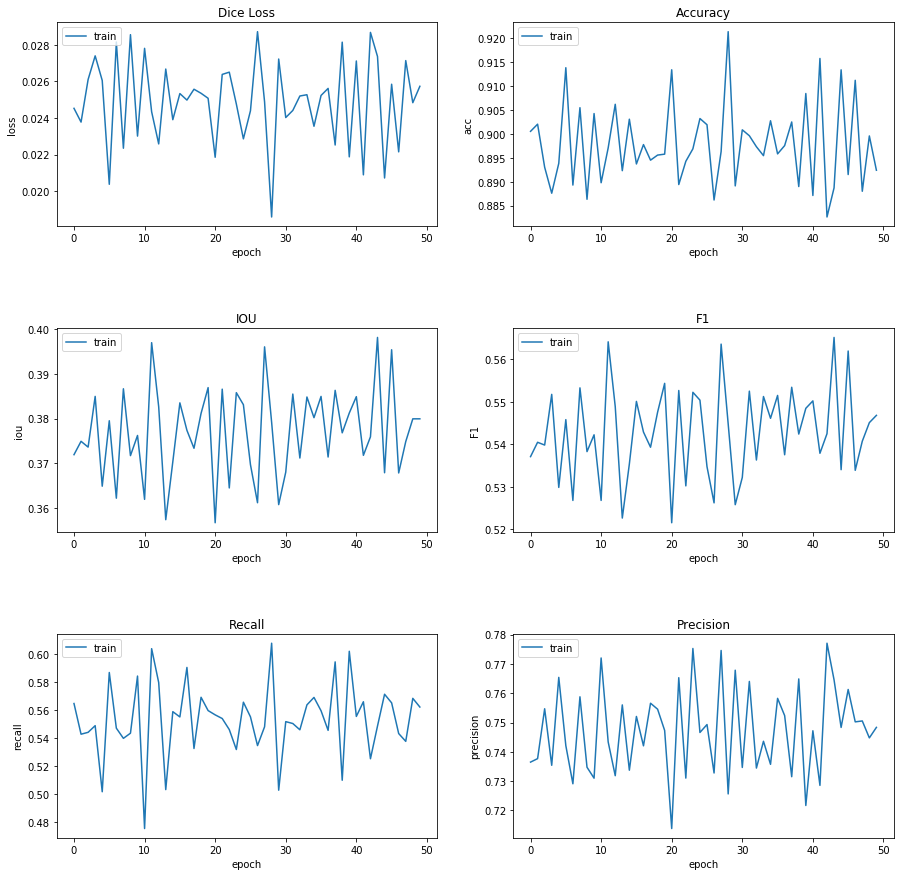

In [ ]:
training_history_plot(results) # Plots "training curve" for the network/model for metrics listed above. See plots.py for more details

## 4- Model's Performance on various Metrics

In [ ]:
titles = ['Dice Loss','Accuracy','IOU','F1','Recall','Precision']
test_generator=test_data_aug() # Peforms real-time Data Augmentation(here only re-scaling and converting to grayscale) on the Test/Validation dataset. See augmentation.py for more details
performance=m.evaluate_generator(test_generator, verbose=1,steps=17)

for i in range(6):
  print("%s = %f" %(titles[i], performance[i]))

Found 17 images belonging to 1 classes.
Found 17 images belonging to 1 classes.
17/17 [==============================] - 1s 39ms/step
Dice Loss = 0.043268
Accuracy = 0.891285
IOU = 0.241737
F1 = 0.381021
Recall = 0.337300
Precision = 0.727956


In [ ]:
#!unzip test2.zip- Folder which contains the dataset for Test performance evaluation

### 4.1- Structure of test2 directory

- test2
    * 0
        * 0
            * 0.png
    * 1
        * 1
            * 1.png
            
Such weird file structure is because there should be **"two" nested directories** in the container directory(test2)

In [ ]:
results=np.zeros(shape=(17,256,256,1))
for i in range(17): # As we have 17 test images 
  results[i,:,:,:]=predict(i, m) # Predicts the segmentation labels on images in test2 directory. See utils.py for more details

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 49ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 44ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 51ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 49ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 51ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 51ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 55ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 45ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 45ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 51ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 54ms/step

## 5- Sample Results

Starting from the left:
    - First image is original test image "converted" to grayscale
    - Second is the predicted segmentation labels for above image
    - Third one is a Binary mask ie. pixel values of only 0's and 1's, obtained by thresholding on Predicted segmentation, below is for threshold value 0.2, implies all pixel values greater than 0.2 in Predicted segmentation get 1 and others get 0
    - Rightmost is the Ground Truth segmentation label for this test image
    
Below we see that segmentation results are very good considering the fact that we had only 33 images our training dataset which is very limited! 

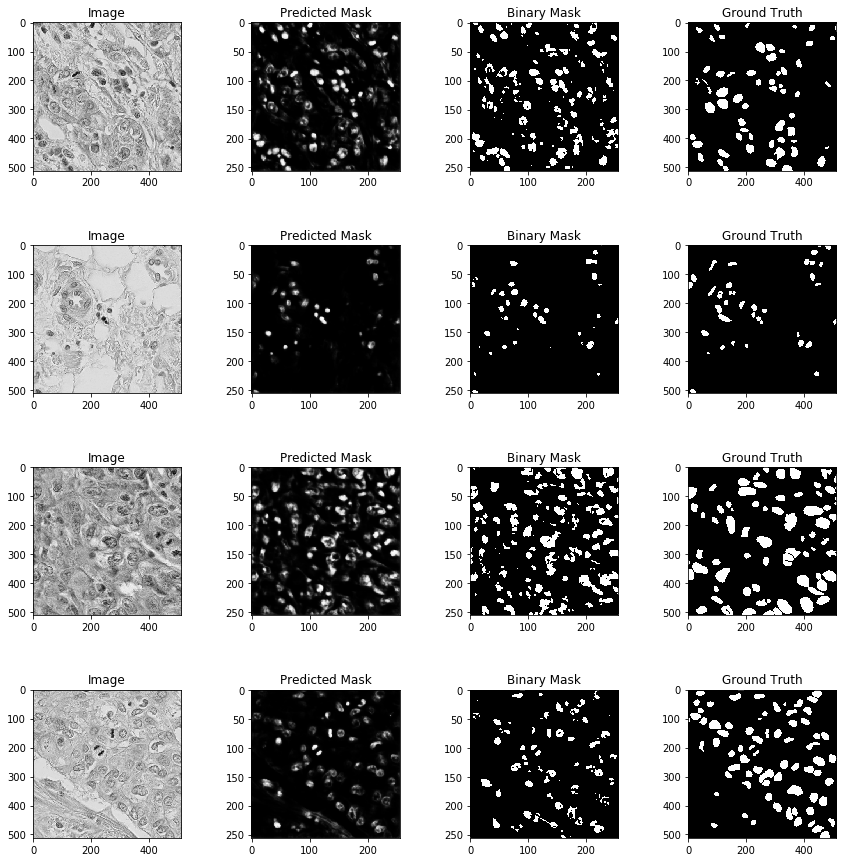

In [ ]:
model_prediction_plot(results, t=0.2) # See plots.py for more details

## 6- Model training on Canny Dataset

In [29]:
# Loads and initalises another U-Net network. This will be trained on dataset "overlayed" with their corresponding Canny Edges

m_c=unet()
m_c.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 256, 256, 64) 640         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_97[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_98[0][0]                  
____________________________________________________________________________________________

/content/model.py:69: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


In [ ]:
#!unzip canny.zip - Folder which contains test and train datasets overlayed with Canny Edges

In [ ]:
opt_c = Adam(lr=1E-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
m_c.compile(loss=dice_coef_loss, optimizer=opt_c, metrics=['accuracy', iou, F1, recall, precision])

In [55]:
checkpoint_c = ModelCheckpoint('unet_canny_weights.hdf5', monitor='loss', 
                             verbose=1, save_best_only=True, mode='min') # Different checkpoint for storing "only" best wieghts during training
                                                                         # Weights will be saved in file named 'unet_canny_weights.hdf5'
train_generator_c=train_data_aug(True) # Peforms real-time Data Augmentation on the Canny Training dataset. See augmentation.py for more details
results_c = m_c.fit_generator(train_generator_c, epochs=100, steps_per_epoch = 8, callbacks=[checkpoint_c])

Found 33 images belonging to 1 classes.
Found 33 images belonging to 1 classes.
Epoch 1/100
8/8 [==============================] - 4s 558ms/step - loss: 0.0277 - acc: 0.9025 - iou: 0.2375 - F1: 0.3804 - recall: 0.4536 - precision: 0.6941

Epoch 00001: loss improved from inf to 0.02770, saving model to unet_canny_weights.hdf5
Epoch 2/100
8/8 [==============================] - 1s 106ms/step - loss: 0.0306 - acc: 0.8856 - iou: 0.2603 - F1: 0.4088 - recall: 0.5022 - precision: 0.6694

Epoch 00002: loss did not improve from 0.02770
Epoch 3/100
8/8 [==============================] - 1s 97ms/step - loss: 0.0361 - acc: 0.8698 - iou: 0.2527 - F1: 0.4002 - recall: 0.3802 - precision: 0.7324

Epoch 00003: loss did not improve from 0.02770
Epoch 4/100
8/8 [==============================] - 1s 102ms/step - loss: 0.0233 - acc: 0.9093 - iou: 0.2539 - F1: 0.4013 - recall: 0.4341 - precision: 0.7124

Epoch 00004: loss improved from 0.02770 to 0.02332, saving model to unet_canny_weights.hdf5
Epoch 5/100

## 7- Plotting model's training history on Canny dataset

### 7.1- Why is the Learning Curve such?

I've trained the model before many times and in previous trainings the "Learning Curve" was exactly as a good learning curve should be ie. noisier but "trending" downwards for the Loss function.

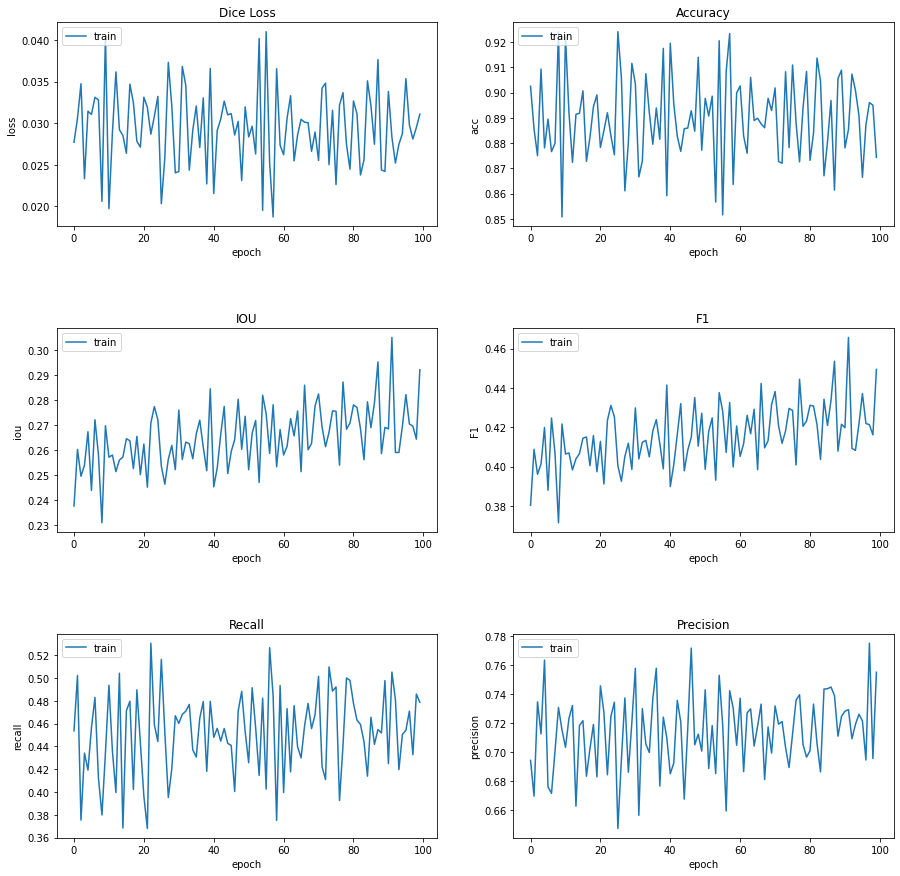

In [56]:
training_history_plot(results_c)

## 8- Model's Performance on various Metrics trained on Canny dataset

In [ ]:
#!unzip test.zip

In [57]:
titles = ['Dice Loss','Accuracy','IOU','F1','Recall','Precision']
test_generator_c=test_data_aug(True) # Peforms real-time Data Augmentation(here only re-scaling and converting to grayscale) on the Test/Validation Canny dataset. See augmentation.py for more details
performance_c=m_c.evaluate_generator(test_generator_c, verbose=1,steps=17)

for i in range(6):
  print("%s = %f" %(titles[i], performance_c[i]))

Found 17 images belonging to 1 classes.
Found 17 images belonging to 1 classes.
17/17 [==============================] - 1s 73ms/step
Dice Loss = 0.046289
Accuracy = 0.889649
IOU = 0.238082
F1 = 0.376991
Recall = 0.535058
Precision = 0.611523


In [ ]:
results_c=np.zeros(shape=(17,256,256,1))
# Predicts the segmentation labels on images in test2 directory. Note: Test dataset has also undergone Canny "overlay"
# as our model was trained on Canny "overlayed" images 
for i in range(17):
  results_c[i,:,:,:]=predict(i, m_c) # See utils.py for more details

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 409ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 44ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 56ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 48ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 50ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 53ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 50ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 43ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 44ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 48ms/step
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 50ms/ste

## 9- Activation Map on Canny dataset

Below is the visualisation of Activation Maps of the model trained on Canny dataset. These visuals are the *activations or the output* of given layer and channel of U-Net CNN. These visualisations tell us **What the model has learnt** or more specifically what the convolutional filters have learnt! It also gives a sense of the **other Biological/Medical features** in the image.

Starting from the left:
    - First image is original test image
    - Second is the Activation Map for provided layer and channel
    - Third one is the Transparent "overlay" of the Activation Map over the test image
For more information see plots.py

**Note:** As I'm using **'jet' cmap** so red corresponds to high activation values and blue to low ones, and green/yellow in the middle in the Activation Map.

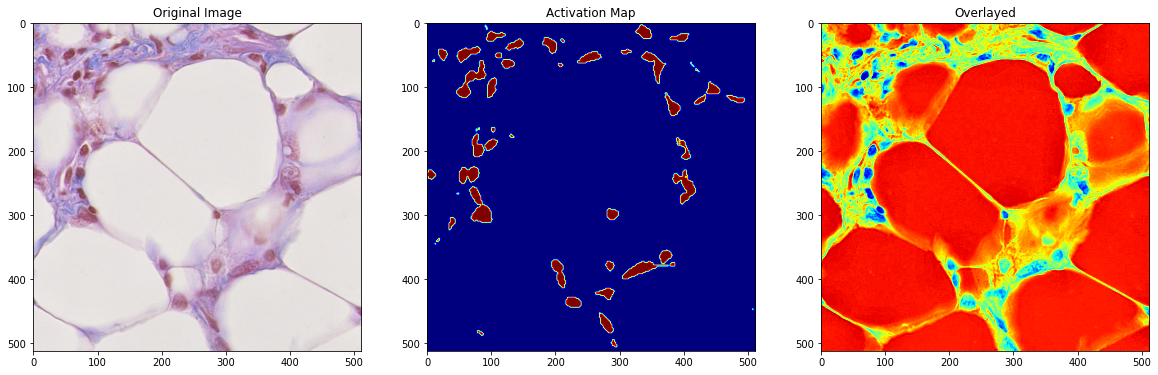

In [58]:
activation_map('9.png',38,0, m_c)

The filter corresponding to the last layer and it's only filter has learnt to **segment Cancer cells**, marked in red in the second image! When overlayed on the original image clearly distinguishes Cancer and non-Cancer cells.

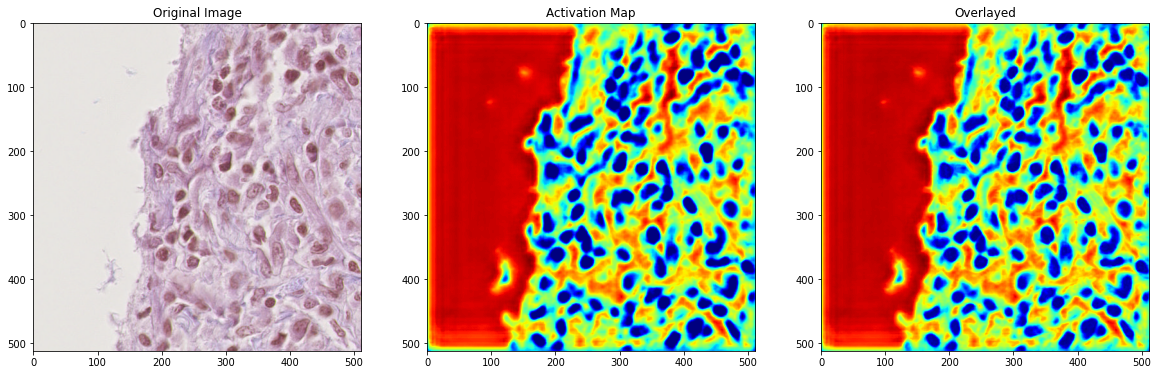

In [85]:
activation_map('22.png',37,0,m_c)

As clearly seen above the corresponding filter has learnt to identify **empty regions** see red region in centre image, remember "Red" corresponds to high activation in Activation Map! Also note that Cancer cells have low activations here, marked in blue so in a way *this filter is ignoring those cells.*

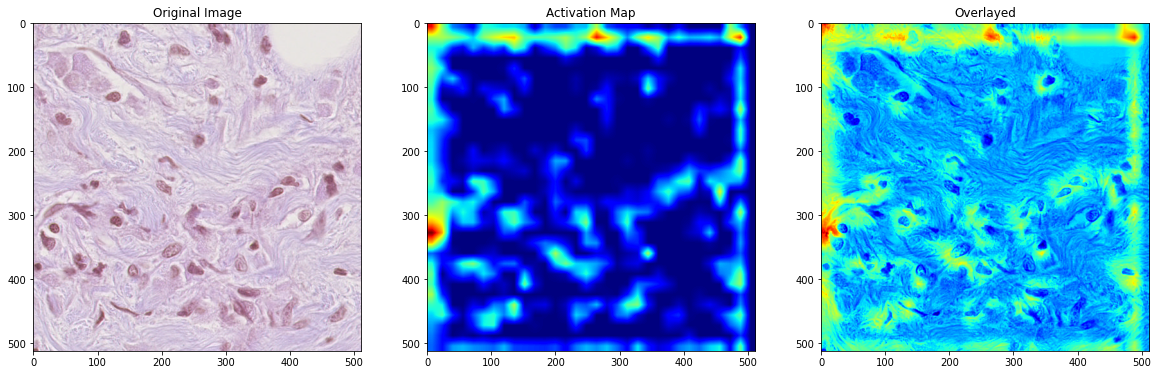

In [99]:
activation_map('15.png',11,298,m_c)

Above is the visual for a middle Conv layer, thus it's neither seeing the entire image as it is nor it's segmentation mask! The "Light Blue" marks in the Activation Map shows that this is *tending to learn to segment Cancer cells.*

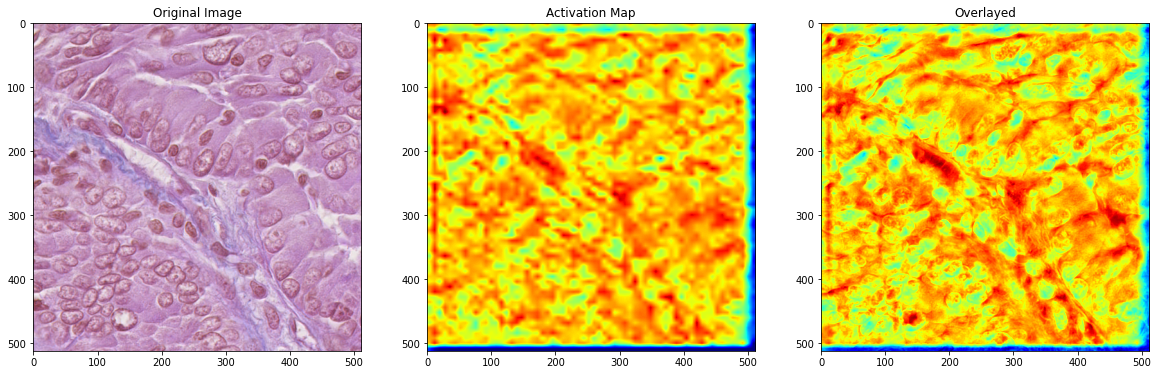

In [74]:
activation_map('0.png',8,0,m_c)

Above visual is for a starting Conv layer it seem to *capture basic features* in the image like edges, gaps between Cancer cells etc. marked in red/yellow.

## 10- Sample Results on Canny Dataset

Starting from the left:
    - First image is original test image "converted" to grayscale
    - Second is the predicted segmentation labels for above image
    - Third one is a Binary mask ie. pixel values of only 0's and 1's, obtained by thresholding on Predicted segmentation, below is for threshold value 0.3, implies all pixel values greater than 0.3 in Predicted segmentation get 1 and others get 0
    - Rightmost is the Ground Truth segmentation label for this test image
    
Below we see that segmentation results are very good considering the fact that we had only 33 images our training dataset which is very limited! 

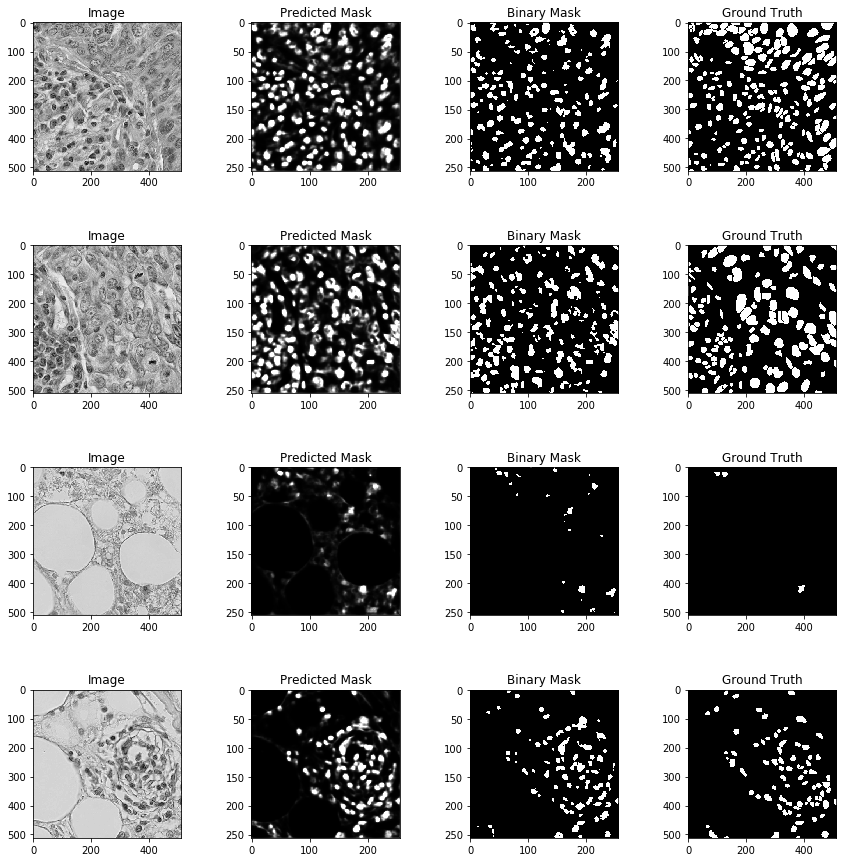

In [ ]:
model_prediction_plot(results_c, 0.3) # See plots.py for more details

## 11- Comparing model's prediction for both Dataset training

Starting from the left:
    - First image is original test image "converted" to grayscale
    - Second is the predicted segmentation labels for above image using model trained on Standard Dataset
    - Third one is the predicted segmentation labels for above image using model trained on Canny "overlayed" Dataset
    - Fourth is a Binary mask ie. pixel values of only 0's and 1's, obtained by thresholding on Predicted segmentation(from Standard dataset), below is for threshold value 0.1(see plots.py), implies all pixel values greater than 0.1 in Predicted segmentation get 1 and others get 0
    - Fifth one is a Binary mask ie. pixel values of only 0's and 1's, obtained by thresholding on Predicted segmentation(from Canny "overlayed" dataset), below is for threshold value 0.2(see plots.py), implies all pixel values greater than 0.2 in Predicted segmentation get 1 and others get 0
    - Rightmost is the Ground Truth segmentation label for this test image
    
***Below we see that segmentation results from model trained on Canny dataset is better than the one trained on the Standard Dataset!***

**Note:** The text labels for 3rd and 4th images below are swapped, the correct order is as listed above

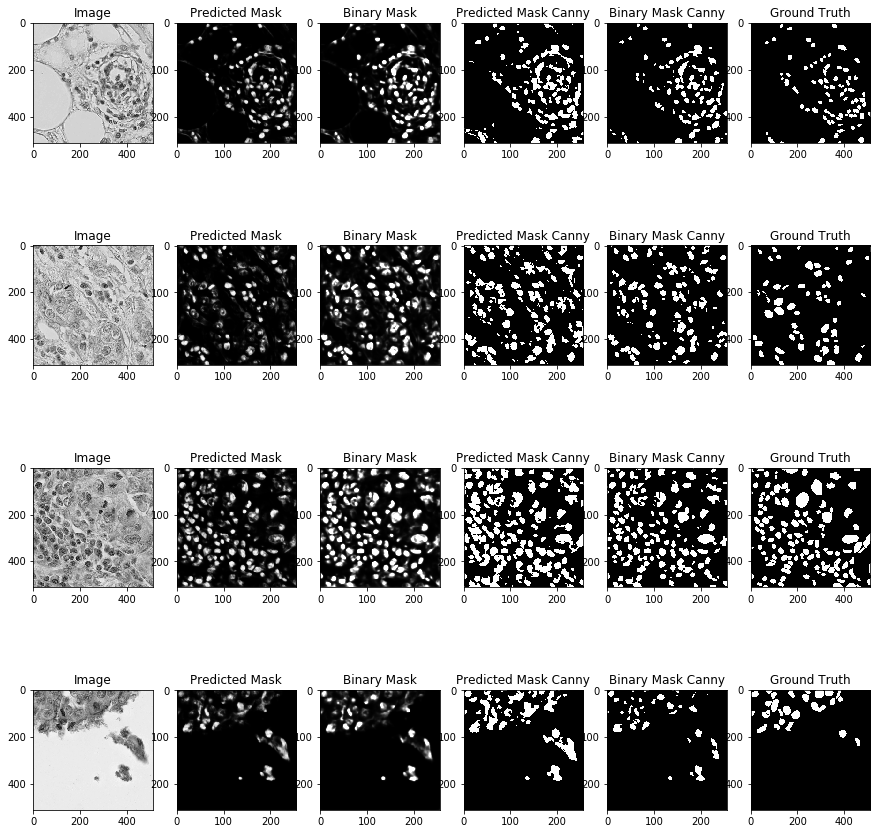

In [ ]:
canny_compare_plot(results, results_c) # Compares model's performance on the "standard" dataset and dataset "overlayed" with "canny edges"

## 12- References

1. [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
2. [Triple Negative Breast Cancer- American Cancer Society](https://www.cancer.org/cancer/breast-cancer/understanding-a-breast-cancer-diagnosis/types-of-breast-cancer/triple-negative.html)
3. [Deep Learning for Cancer Cell Detection and Segmentation: A Survey](https://www.researchgate.net/publication/334080872_Deep_Learning_for_Cancer_Cell_Detection_and_Segmentation_A_Survey)
4. [Transfusion: Understanding Transfer Learning for Medical Imaging](https://arxiv.org/abs/1902.07208)
5. [Dataset](https://zenodo.org/record/1175282#.Xl_4nZMzZQJ)

**Note:** Not an exhaustive list